# Machine Learning Practice Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

## Data Generation

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Number of records
n = 1000

# Generate random data
age = np.random.randint(18, 65, n)
annual_salary = np.random.randint(20_000, 120_000, n)
credit_score = np.round(np.random.uniform(0, 1, n), 2)
stable_employment = np.random.randint(0, 2, n)
own_house = np.random.randint(0, 2, n)

# Generate the target column (Approved) with some arbitrary logic
approved = np.where((annual_salary > 50_000) & (credit_score > 0.6), 1, 0)

# Create the DataFrame
df = pd.DataFrame({
    'Age': age,
    'Annual_Salary': annual_salary,
    'Credit_Score': credit_score,
    'Stable_Employment': stable_employment,
    'Own_House': own_house,
    'Approved': approved
})

# Add Gaussian noise to numeric features
noise_scale = 0.05  # Standard deviation of the noise
noisy_columns = ['Annual_Salary', 'Credit_Score']
for col in noisy_columns:
    noise = np.random.normal(0, noise_scale, n)
    df[col] += noise

# Flip some labels in the Approved column (approximately 1%)
flip_rate = 0.01
n_flip = int(n * flip_rate)
flip_indices = np.random.choice(df.index, size=n_flip, replace=False)
df.loc[flip_indices, 'Approved'] = 1 - df.loc[flip_indices, 'Approved']

df.head()

,Age,Annual_Salary,Credit_Score,Stable_Employment,Own_House,Approved
0,56,25287.109403,0.543064,0,1,0
1,46,54387.026600,0.747804,0,0,1
2,32,28511.959349,0.228517,0,1,0
3,60,21342.036699,0.683238,0,0,0
4,25,83076.064871,0.371736,0,1,0


## Exploratory Data Analysis (EDA)

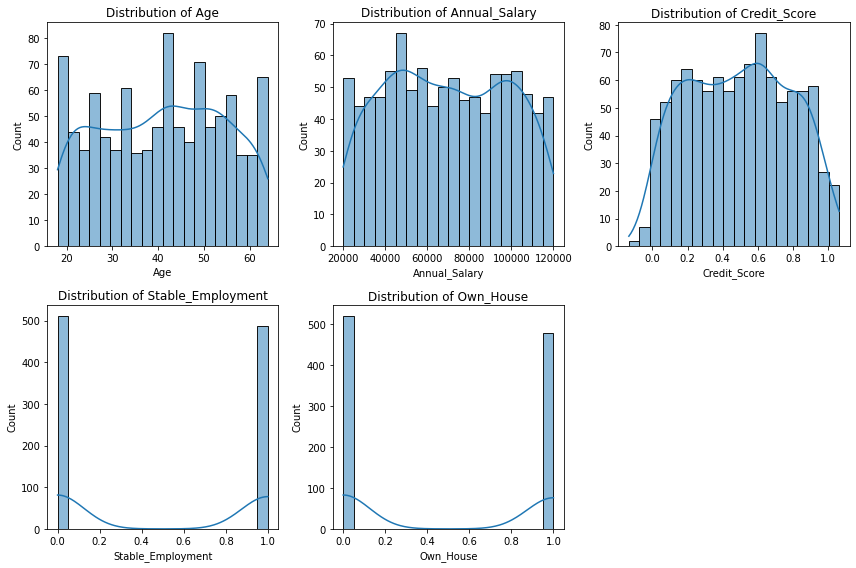

Descriptive Statistics:
               Age  Annual_Salary  Credit_Score  Stable_Employment  \
count  1000.000000    1000.000000   1000.000000        1000.000000   
mean     40.986000   69404.683088      0.491725           0.488000   
std      13.497852   28581.017516      0.288317           0.500106   
min      18.000000   20060.067456     -0.133512           0.000000   
25%      29.000000   45518.997333      0.244734           0.000000   
50%      42.000000   68815.970277      0.493434           0.000000   
75%      52.000000   94672.269800      0.730649           1.000000   
max      64.000000  119986.046210      1.061940           1.000000   

         Own_House     Approved  
count  1000.000000  1000.000000  
mean      0.479000     0.281000  
std       0.499809     0.449712  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       1.000000     1.000000  
max       1.000000     1.000000  

Class Distribution:
0    71.9
1    28.

In [3]:
# Descriptive statistics
desc_stats = df.describe()

# Class distribution
class_dist = df['Approved'].value_counts(normalize=True) * 100

# Plots
plt.figure(figsize=(12, 8))

# Histograms for the features
for i, col in enumerate(df.columns[:-1], 1):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

# Correlation matrix
correlation_matrix = df.corr()

# Display the outputs
print("Descriptive Statistics:")
print(desc_stats)
print("\nClass Distribution:")
print(class_dist)
print("\nCorrelation Matrix:")
print(correlation_matrix)

In [4]:
# Specific analysis for rejected cases
rejected_df = df[df['Approved'] == 0]

# Descriptive statistics for rejected cases
desc_stats_rejected = rejected_df.describe()

# Correlation matrix for rejected cases
correlation_matrix_rejected = rejected_df.corr()

# Specific analysis for approved cases
approved_df = df[df['Approved'] == 1]

# Descriptive statistics for approved cases
desc_stats_approved = approved_df.describe()

# Correlation matrix for approved cases
correlation_matrix_approved = approved_df.corr()

# Display the additional outputs
print("\nDescriptive Statistics for Rejected Cases:")
print(desc_stats_rejected)
print("\nCorrelation Matrix for Rejected Cases:")
print(correlation_matrix_rejected)
print("\nDescriptive Statistics for Approved Cases:")
print(desc_stats_approved)
print("\nCorrelation Matrix for Approved Cases:")
print(correlation_matrix_approved)


Descriptive Statistics for Rejected Cases:
              Age  Annual_Salary  Credit_Score  Stable_Employment   Own_House  \
count  719.000000     719.000000    719.000000         719.000000  719.000000   
mean    40.924896   64109.928672      0.378909           0.502086    0.486787   
std     13.542770   29595.982716      0.250796           0.500344    0.500173   
min     18.000000   20060.067456     -0.133512           0.000000    0.000000   
25%     29.500000   39232.982297      0.175520           0.000000    0.000000   
50%     42.000000   58709.007449      0.363196           1.000000    0.000000   
75%     52.000000   90918.099246      0.542904           1.000000    1.000000   
max     64.000000  119928.956086      1.061940           1.000000    1.000000   

       Approved  
count     719.0  
mean        0.0  
std         0.0  
min         0.0  
25%         0.0  
50%         0.0  
75%         0.0  
max         0.0  

Correlation Matrix for Rejected Cases:
                        

## Random Forest Model for Feature Importance

In [5]:
# Separate features and target variable
X = df.drop('Approved', axis=1)
y = df['Approved']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

accuracy, feature_importance

(0.955,
              Feature  Importance
 2       Credit_Score    0.612293
 1      Annual_Salary    0.330566
 0                Age    0.045096
 3  Stable_Employment    0.006760
 4          Own_House    0.005285)

## Neural Network Model

In [6]:
# Remove less important features
X_reduced = X.drop(['Age', 'Own_House', 'Stable_Employment'], axis=1)

# Split data into training and test sets (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=42)

# Scale the data
scaler = StandardScaler()

# Fit on training set and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create Neural Network model
nn_model = MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=500, random_state=42)

# Train the model
nn_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred_nn = nn_model.predict(X_test_scaled)

# Evaluate the model
accuracy_nn = accuracy_score(y_test, y_pred_nn)

accuracy_nn

0.97

## XGBoost Model and Confusion Matrices

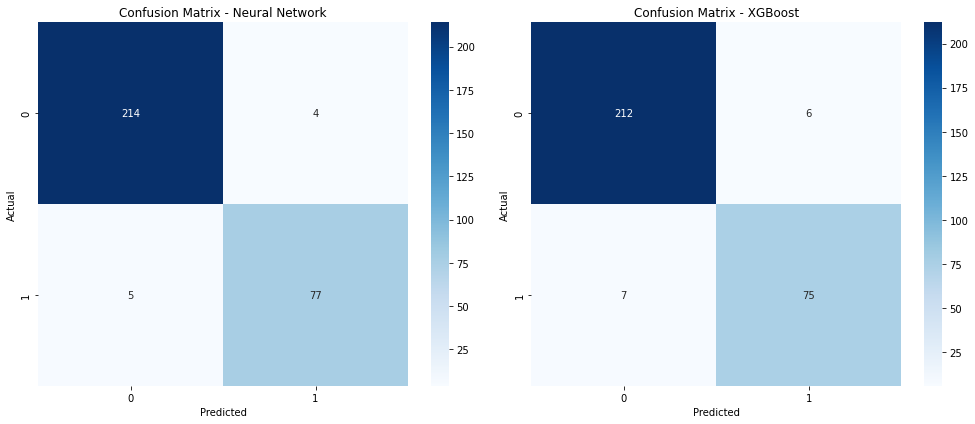

0.9566666666666667

In [7]:
# Create XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train XGBoost model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

# Confusion matrices
cm_nn = confusion_matrix(y_test, y_pred_nn)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_nn, annot=True, fmt='g', cmap='Blues', ax=ax[0])
ax[0].set_title('Confusion Matrix - Neural Network')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(cm_xgb, annot=True, fmt='g', cmap='Blues', ax=ax[1])
ax[1].set_title('Confusion Matrix - XGBoost')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

accuracy_xgb

## Performance Metrics

In [8]:
# Metrics for Neural Network model
accuracy_nn = accuracy_score(y_test, y_pred_nn)
precision_nn = precision_score(y_test, y_pred_nn)
recall_nn = recall_score(y_test, y_pred_nn)
f1_nn = f1_score(y_test, y_pred_nn)
mcc_nn = matthews_corrcoef(y_test, y_pred_nn)

# Metrics for XGBoost model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
mcc_xgb = matthews_corrcoef(y_test, y_pred_xgb)

metrics_nn = {
    'Accuracy': accuracy_nn,
    'Precision': precision_nn,
    'Recall': recall_nn,
    'F1 Score': f1_nn,
    'MCC': mcc_nn
}

metrics_xgb = {
    'Accuracy': accuracy_xgb,
    'Precision': precision_xgb,
    'Recall': recall_xgb,
    'F1 Score': f1_xgb,
    'MCC': mcc_xgb
}

metrics_nn, metrics_xgb

({'Accuracy': 0.97,
  'Precision': 0.9506172839506173,
  'Recall': 0.9390243902439024,
  'F1 Score': 0.9447852760736196,
  'MCC': 0.924224162083538},
 {'Accuracy': 0.9566666666666667,
  'Precision': 0.9259259259259259,
  'Recall': 0.9146341463414634,
  'F1 Score': 0.9202453987730062,
  'MCC': 0.8905302443991218})